In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from params import *
import tqdm
import ghibtools as gh
import seaborn as sns
import pingouin as pg
%matplotlib inline

In [3]:
print(patient)

P10


## SAVING CHOSE

In [4]:
save_cycles_with_spindle = False

## PARAMS

In [5]:
nbins = 2

## LOAD RESP FEATURES & SPINDLES FEATURES

In [6]:
def load_df(patient , stage_to_study=stage_to_study):
    spindle_file = f'../df_analyse/spindles_{patient}.xlsx'
    rsp_cycle_file = f'../df_analyse/resp_features_new_{patient}.xlsx'
    df_cycles = pd.read_excel(rsp_cycle_file, index_col = 0)
    spindles = pd.read_excel(spindle_file).drop(columns = 'Unnamed: 0')
    spindles = spindles[spindles['stage'] == stage_to_study]
    end_cycles = []
    for cycle in range(df_cycles.shape[0]):
        end_resp = df_cycles.loc[cycle, 'inspi_time'] + df_cycles.loc[cycle, 'cycle_duration']
        end_cycles.append(end_resp)
    df_cycles['end_time'] = end_cycles
    df_cycles
    
    return df_cycles , spindles

In [7]:
df_cycles , spindles = load_df(patient)

In [8]:
df_cycles

,Unnamed: 0,patient,cycle_num,inspi_index,expi_index,inspi_time,expi_time,cycle_duration,insp_duration,exp_duration,cycle_freq,insp_volume,exp_volume,total_amplitude,insp_amplitude,exp_amplitude,end_time
0,0,P10,0,9,315,0.035156,1.230469,3.218750,1.195312,2.023438,0.310680,70.149251,35.250572,101.332140,70.477427,30.854713,3.253906
1,1,P10,1,833,1149,3.253906,4.488281,3.484375,1.234375,2.250000,0.286996,76.714018,41.101259,109.483597,78.546267,30.937330,6.738281
2,2,P10,2,1725,2081,6.738281,8.128906,3.496094,1.390625,2.105469,0.286034,80.284087,37.333431,99.036470,68.051436,30.985034,10.234375
3,3,P10,3,2620,2982,10.234375,11.648438,3.363281,1.414062,1.949219,0.297329,73.256394,33.306419,93.975076,63.056873,30.918203,13.597656
4,4,P10,4,3481,3791,13.597656,14.808594,3.449219,1.210938,2.238281,0.289921,75.739948,40.251144,109.223979,78.179055,31.044925,17.046875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,1687,P10,1687,1813931,1814254,7085.667969,7086.929688,2.914062,1.261719,1.652344,0.343164,79.005229,7.133767,112.294064,81.305451,30.988612,7088.582031
1685,1688,P10,1688,1814677,1814990,7088.582031,7089.804688,3.496094,1.222656,2.273438,0.286034,80.071477,18.720356,114.306694,83.273309,31.033386,7092.078125
1686,1689,P10,1689,1815572,1815900,7092.078125,7093.359375,3.144531,1.281250,1.863281,0.318012,88.749161,10.335936,125.269604,94.430902,30.838703,7095.222656
1687,1690,P10,1690,1816377,1816681,7095.222656,7096.410156,3.453125,1.187500,2.265625,0.289593,84.251904,17.570151,119.336883,88.696413,30.640469,7098.675781


In [9]:
spindles

,patient,stage,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
180,P10,N2,4.253906,4.722656,5.363281,1.109375,48.304384,9.593304,1.896777,0.420378,12.280584,13,0.421053,Fp2-C4,0
181,P10,N2,23.078125,23.281250,23.609375,0.531250,28.306916,7.323837,1.813016,0.390438,12.538347,7,0.379562,Fp2-C4,0
182,P10,N2,33.667969,33.980469,34.273438,0.605469,36.242581,8.118359,1.796433,0.261610,11.926052,7,0.512821,Fp2-C4,0
183,P10,N2,51.339844,51.832031,52.167969,0.828125,28.222252,6.654932,1.767579,0.464829,12.585936,11,0.591549,Fp2-C4,0
184,P10,N2,117.804688,118.375000,118.816406,1.011719,53.490489,11.261966,1.922048,0.320993,12.951341,13,0.561538,Fp2-C4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,P10,N2,7449.910156,7450.089844,7450.464844,0.554688,31.118556,6.772215,1.478077,0.236618,13.017753,6,0.321678,T3-O1,7
2848,P10,N2,7509.289062,7509.449219,7509.812500,0.523438,25.437377,5.836279,1.679451,0.396657,13.624334,7,0.303704,T3-O1,7
2849,P10,N2,8001.078125,8001.460938,8001.707031,0.628906,31.801027,7.156477,1.765386,0.385709,13.726640,8,0.604938,T3-O1,7
2850,P10,N2,8584.031250,8584.339844,8584.675781,0.644531,34.620598,8.311678,1.893966,0.429671,13.607499,9,0.475904,T3-O1,7


## COMPUTE WHICH CYCLE CONTAINS SPINDLES

In [10]:
def which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles, patient=patient):
    spindles_times = spindles['Peak'].values

    count = []

    for cycle in range(df_cycles.shape[0]):

        start = df_cycles.loc[cycle,'inspi_time']
        stop = df_cycles.loc[cycle,'end_time']
        
        for spindle_time in spindles_times:
            if spindle_time >= start and spindle_time < stop:
                count.append(cycle)
    cycles_with_spindle = pd.Series(count).unique()

    return cycles_with_spindle

In [11]:
cycles_spindled = which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles)

In [12]:
if save_cycles_with_spindle:
    print(f'saving {patient}')
    np.save(f'../df_analyse/cycles_spindled_{patient}', cycles_spindled)

In [13]:
cycles_spindled.size

755

## COMPUTE WHICH RESP PHASE CONTAINS SPINDLES

In [14]:
def count_spindles_phase_resp(nbins, patient, spindles = spindles, df_cycles = df_cycles, cycle_spindled = cycles_spindled, show=False):
    spindles_times = spindles['Peak']
    
    count = []

    for cycle in cycle_spindled:
        
        start = df_cycles.loc[cycle,'inspi_time']
        stop = df_cycles.loc[cycle,'end_time']

        phases_timings = np.linspace(start, stop, nbins + 1)
        
        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values
        
        for spindle_time in spindles_of_the_cycle:
            for i, phase_start in enumerate(phases_timings):
                if phase_start != phases_timings[-1]:
                    phase_stop = phases_timings[i + 1]
                    if spindle_time >= phase_start and spindle_time < phase_stop:
                        count.append(i)
                        
    phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
    phase_count = phase_count.to_frame().T
    phase_count.insert(0 , 'norm' , 'no')
    phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
    phase_count_norm = phase_count_norm.to_frame().T
    phase_count_norm.insert(0 , 'norm' , 'yes')
    
    df_concat = pd.concat([phase_count, phase_count_norm], axis = 0)
    
    df_concat.insert(0 , 'patient', patient)

    return df_concat

In [15]:
count_spindles_phase_resp(nbins, patient)

,patient,norm,0,1
0,P10,no,859.000000,1020.000000
0,P10,yes,0.457158,0.542842


## LOOP ON PATIENTS AND STAGES

In [16]:
def all_in_one(patient, nbins=nbins, stage='N2'):
    df_cycles , spindles = load_df(patient, stage_to_study=stage)
    cycles_spindled = which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles, patient=patient)
    count = count_spindles_phase_resp(nbins=nbins, patient=patient, spindles = spindles, df_cycles = df_cycles, cycle_spindled = cycles_spindled, show=False)
    count.insert(1 , 'stage' , stage)
    return count

In [17]:
all_in_one(patient='P1',nbins = 2, stage = 'N2')

,patient,stage,norm,0,1
0,P1,N2,no,1028.000000,1171.000000
0,P1,N2,yes,0.467485,0.532515


In [18]:
concat = []
for p in  ['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']:
    print(p)
    for stage in compute_stages:
        concat.append(all_in_one(patient=p, stage=stage))
df = pd.concat(concat)

P1
P2
P3
P4
P5
P6
P7
P8
P9


/tmp/ipykernel_26503/607658360.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_26503/1370126485.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_26503/1370126485.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))


P10


/tmp/ipykernel_26503/607658360.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_26503/1370126485.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_26503/1370126485.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))


In [19]:
df

,patient,stage,norm,0,1
0,P1,W,no,25.000000,36.000000
0,P1,W,yes,0.409836,0.590164
0,P1,R,no,NaN,3.000000
0,P1,R,yes,NaN,1.000000
0,P1,N2,no,1028.000000,1171.000000
...,...,...,...,...,...
0,P10,R,yes,0.375000,0.625000
0,P10,N2,no,859.000000,1020.000000
0,P10,N2,yes,0.457158,0.542842
0,P10,N3,no,NaN,NaN


In [20]:
concat = []
for p in  ['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']:
    print(p)
    for stage in compute_stages:
        concat.append(all_in_one(patient=p,nbins = 3, stage=stage))
df_3 = pd.concat(concat)

P1
P2
P3
P4
P5
P6
P7
P8
P9


/tmp/ipykernel_26503/607658360.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_26503/1370126485.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_26503/1370126485.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))


P10


/tmp/ipykernel_26503/607658360.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_26503/1370126485.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_26503/1370126485.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))


In [21]:
to_plot_3 = df_3[(df_3['norm'] == 'yes') & (df_3['stage'] == 'N2') ]

<AxesSubplot:xlabel='patient,norm,stage'>

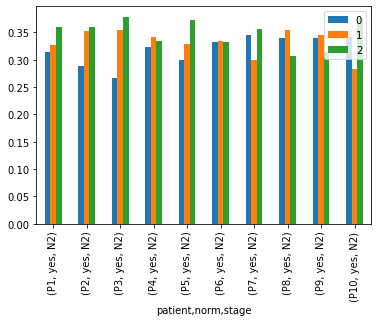

In [22]:
to_plot_3.set_index(['patient','norm','stage']).plot.bar()

In [23]:
def to_tidy(df, nbins=2, indexes = ['patient','stage','norm']):
    df = df.set_index(indexes)
    rows = []
    for patient in patients:
        for stage in compute_stages:
            for norm in ['no','yes']:
                for bin_i in range(nbins):

                    count_bin_i = df.loc[(patient, stage, norm), bin_i]
                    row = [patient, stage, norm, bin_i, count_bin_i]
                    rows.append(row)
                
    df_tidy = pd.DataFrame(rows, columns = ['patient' , 'stage', 'norm', 'phase' , 'count'])
    return df_tidy

df_tidy = to_tidy(df)
df_tidy

,patient,stage,norm,phase,count
0,P1,W,no,0,25.000000
1,P1,W,no,1,36.000000
2,P1,W,yes,0,0.409836
3,P1,W,yes,1,0.590164
4,P1,R,no,0,NaN
...,...,...,...,...,...
155,P10,N2,yes,1,0.542842
156,P10,N3,no,0,NaN
157,P10,N3,no,1,NaN
158,P10,N3,yes,0,NaN


In [24]:
df_tidy.groupby(['stage','norm','phase']).mean()

count
stage norm phase             
N2    no   0      1065.000000
           1      1230.700000
      yes  0         0.467880
           1         0.532120
N3    no   0        17.600000
           1        16.750000
      yes  0         0.398883
           1         0.750698
R     no   0        11.250000
           1        12.400000
      yes  0         0.478024
           1         0.617581
W     no   0        46.200000
           1        47.100000
      yes  0         0.491606
           1         0.508394

In [25]:
df_tidy.groupby(['stage','norm','phase']).std()

count
stage norm phase            
N2    no   0      628.026539
           1      712.710951
      yes  0        0.022772
           1        0.022772
N3    no   0       12.074767
           1       17.621010
      yes  0        0.086560
           1        0.216563
R     no   0       14.577380
           1       16.681327
      yes  0        0.149593
           1        0.240891
W     no   0       31.097696
           1       24.803450
      yes  0        0.093384
           1        0.093384

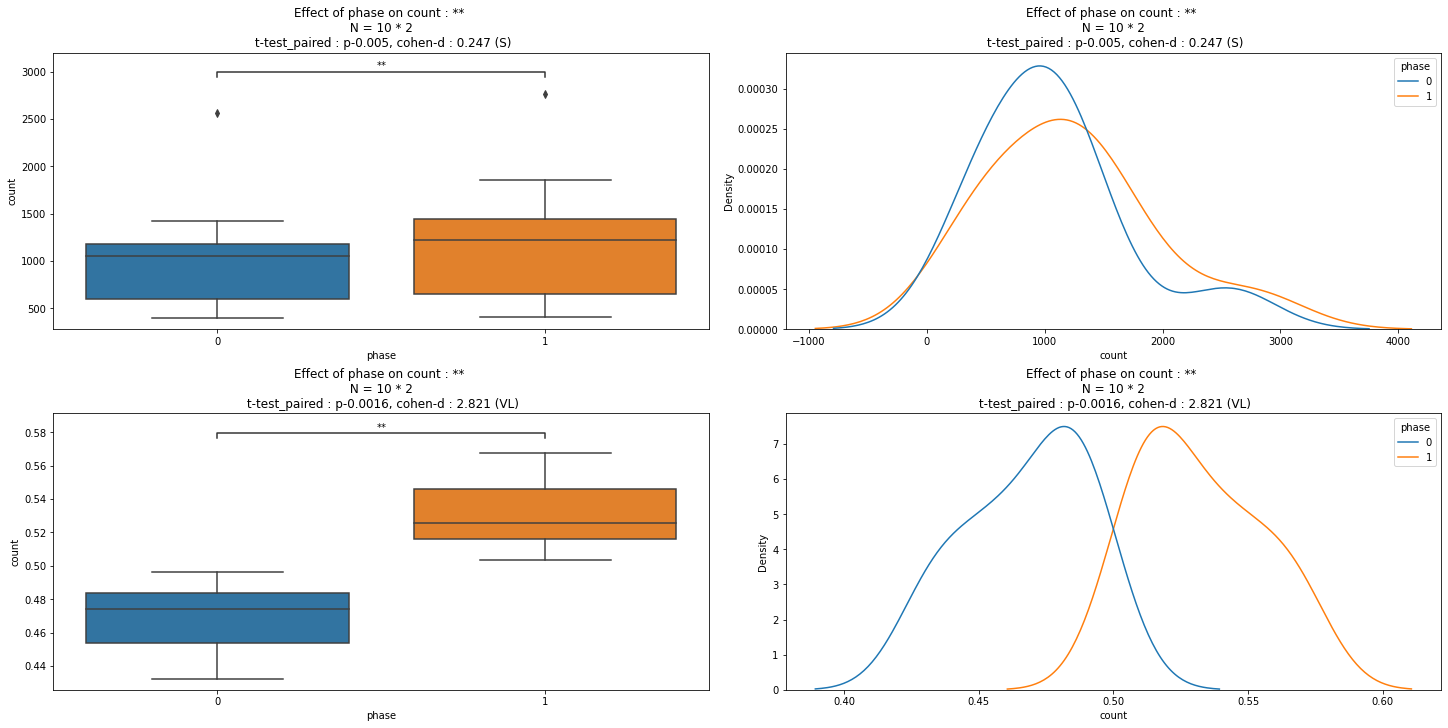

In [26]:
fig ,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (20,10), constrained_layout =True)

for row , norm in enumerate(['no', 'yes']):
    for col, mode in enumerate(['box','distribution']):
        ax = axs[row, col]
        gh.auto_stats(df=df_tidy[(df_tidy['stage'] == 'N2') & (df_tidy['norm'] == norm)] , predictor = 'phase', outcome = 'count' , design = 'within', ax=ax, mode = mode)

In [27]:
bin_1_prop = df_tidy[(df_tidy['stage'] == 'N2') & (df_tidy['norm'] == 'yes') & (df_tidy['phase'] == 1)]['count'].values
bin_0_prop = df_tidy[(df_tidy['stage'] == 'N2') & (df_tidy['norm'] == 'yes') & (df_tidy['phase'] == 0)]['count'].values

In [28]:
ttest = pg.ttest(x = bin_1_prop, y = 0.5)
ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.460383,9,two-sided,0.001576,"[0.52, 0.55]",1.410497,27.991,0.976612


In [29]:
pg.ttest(x = bin_0_prop, y = 0.5)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.460383,9,two-sided,0.001576,"[0.45, 0.48]",1.410497,27.991,0.976612


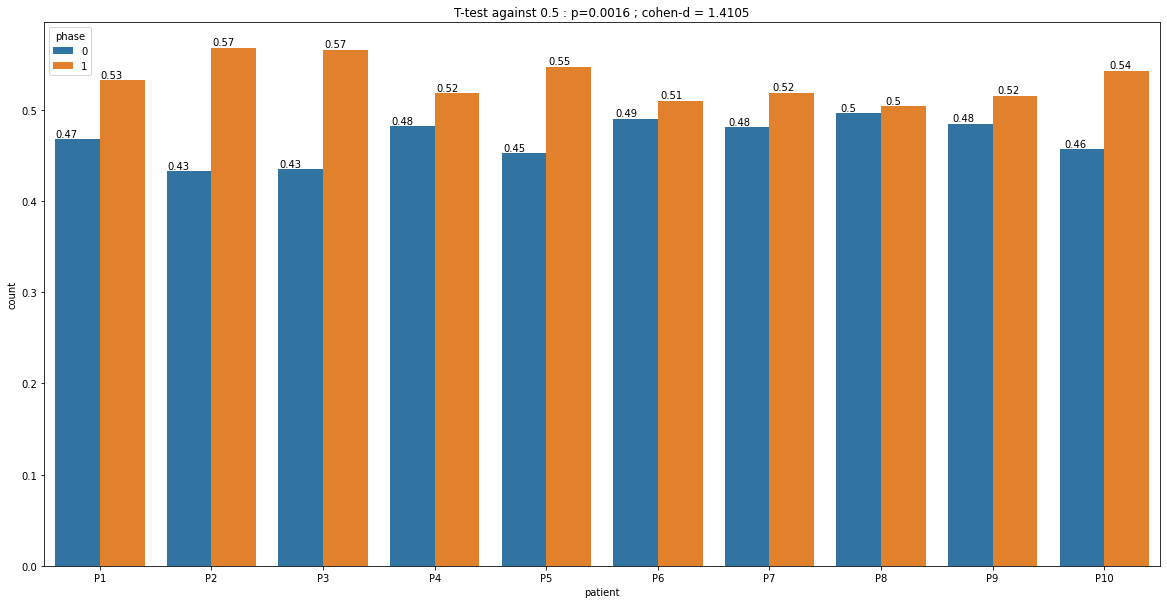

In [30]:
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(data = df_tidy[(df_tidy['stage'] == 'N2') & (df_tidy['norm'] == 'yes')], x='patient', y ='count', hue = 'phase', ax=ax)
p = ttest.loc['T-test', 'p-val'].round(4)
cohen = ttest.loc['T-test', 'cohen-d'].round(4)
ax.set_title(f'T-test against 0.5 : p={p} ; cohen-d = {cohen}')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
# plt.savefig('../presentation_2/bar_2_bins')

In [31]:
for p in ax.patches:
    print(p.get_height())

0.46748522055479763
0.4324734446130501
0.43462359036879
0.48175182481751827
0.45273420941076725
0.490272373540856
0.4813215693636193
0.49625
0.4847250509164969
0.4571580627993614
0.5325147794452023
0.56752655538695
0.5653764096312099
0.5182481751824818
0.5472657905892327
0.5097276264591439
0.5186784306363807
0.50375
0.515274949083503
0.5428419372006387


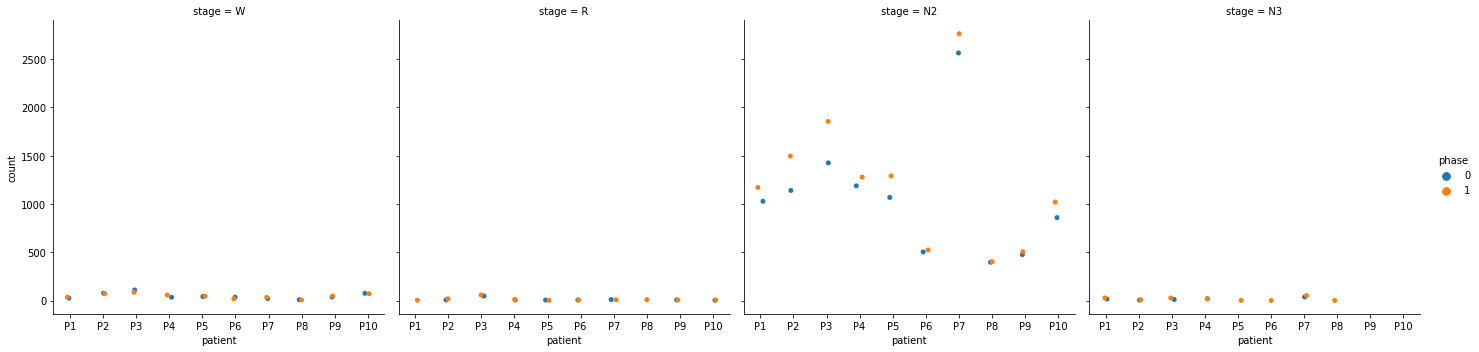

In [32]:
sns.catplot(data = df_tidy[df_tidy['norm'] == 'no'], x='patient', y ='count', hue = 'phase', col = 'stage')

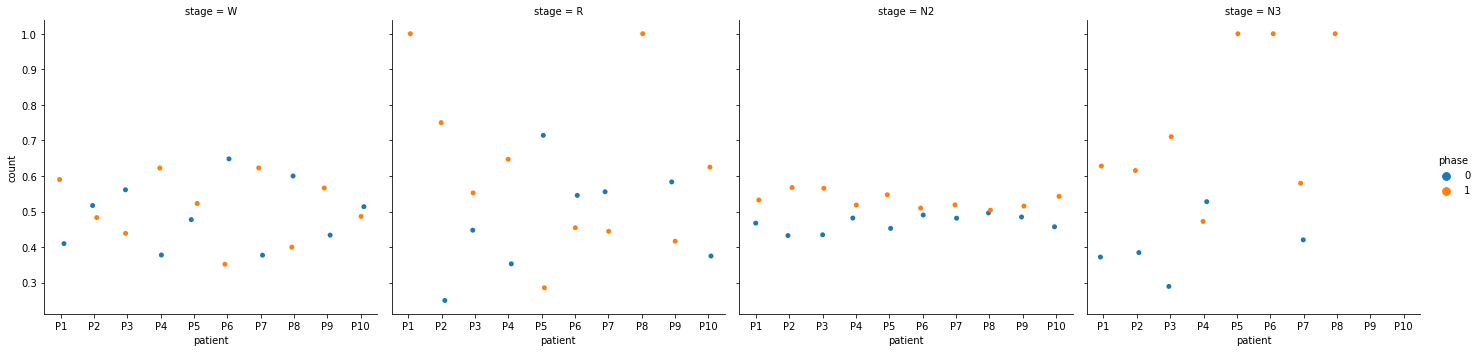

In [33]:
sns.catplot(data = df_tidy[df_tidy['norm'] == 'yes'], x='patient', y ='count', hue = 'phase', col = 'stage')

In [34]:
concat = []
for p in  patients:
    print(p)
    concat.append(all_in_one(p, nbins = 20))


P1
P2
P3
P4
P5
P6
P7
P8
P9
P10


In [35]:
df_20 = pd.concat(concat)

/tmp/ipykernel_26503/3312757182.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_20.mean().plot.bar()


<AxesSubplot:>

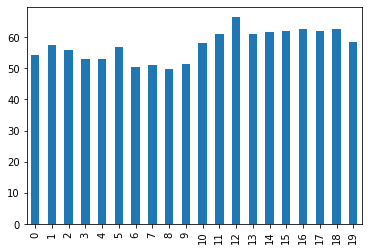

In [36]:
df_20.mean().plot.bar()

In [37]:
df_20

,patient,stage,norm,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,P1,N2,no,116.000000,98.000000,121.000000,95.000000,98.000000,106.000000,101.000000,...,110.000000,114.000000,117.000000,108.000000,114.000000,116.000000,153.000000,125.000000,112.000000,102.000000
0,P1,N2,yes,0.052751,0.044566,0.055025,0.043201,0.044566,0.048204,0.045930,...,0.050023,0.051842,0.053206,0.049113,0.051842,0.052751,0.069577,0.056844,0.050932,0.046385
0,P2,N2,no,116.000000,103.000000,104.000000,120.000000,119.000000,126.000000,116.000000,...,182.000000,181.000000,146.000000,153.000000,151.000000,144.000000,137.000000,139.000000,146.000000,117.000000
0,P2,N2,yes,0.044006,0.039074,0.039454,0.045524,0.045144,0.047800,0.044006,...,0.069044,0.068665,0.055387,0.058042,0.057284,0.054628,0.051973,0.052731,0.055387,0.044385
0,P3,N2,no,162.000000,145.000000,104.000000,112.000000,140.000000,130.000000,129.000000,...,158.000000,175.000000,207.000000,205.000000,209.000000,195.000000,159.000000,185.000000,204.000000,158.000000
0,P3,N2,yes,0.049375,0.044194,0.031698,0.034136,0.042670,0.039622,0.039317,...,0.048156,0.053337,0.063091,0.062481,0.063700,0.059433,0.048461,0.056385,0.062176,0.048156
0,P4,N2,no,118.000000,112.000000,130.000000,116.000000,128.000000,134.000000,105.000000,...,114.000000,139.000000,148.000000,132.000000,152.000000,120.000000,131.000000,116.000000,107.000000,119.000000
0,P4,N2,yes,0.047851,0.045418,0.052717,0.047040,0.051906,0.054339,0.042579,...,0.046229,0.056367,0.060016,0.053528,0.061638,0.048662,0.053122,0.047040,0.043390,0.048256
0,P5,N2,no,78.000000,121.000000,117.000000,111.000000,103.000000,113.000000,101.000000,...,111.000000,115.000000,144.000000,125.000000,137.000000,130.000000,155.000000,146.000000,112.000000,116.000000
0,P5,N2,yes,0.033065,0.051293,0.049597,0.047054,0.043663,0.047902,0.042815,...,0.047054,0.048749,0.061043,0.052989,0.058075,0.055108,0.065706,0.061891,0.047478,0.049173


In [38]:
def get_complex_vector(phase, amplitude, axis = 0):
    #### phase in radian
    #### amplitude 0/1 if spike or whaever positive values if continuous thing
    if np.sum(amplitude<0) >0:
        print('Caution ! Negative amplitude may disturb mesurement !')
    # vectors = np.zeros(phase.shape, dtype ='complex64')
    # vectors[:] = (amplitude*np.exp(1j*phase))
    vectors = amplitude.astype('float32') * np.exp((1j*phase).astype('complex64'))
    # print(vectors.dtype)
    mean_vector = np.nanmean(vectors, axis = axis)
    vectors = 0
    length = abs(mean_vector)
    angle = np.angle(mean_vector)
    if np.isscalar(angle):
        if angle<0:
            angle += 2*np.pi
    elif isinstance(angle, np.ndarray) :
        angle[angle<0] += np.ones(np.sum(angle<0))*2*np.pi
    else :
        print('unknown data type')
        exit()
    return angle, length


In [96]:
df_20_raw = df_20[df_20['norm'] == 'yes']

In [97]:
df_20_raw.mean()

/tmp/ipykernel_26503/2944027958.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_20_raw.mean()


0     0.047893
1     0.050694
2     0.047952
3     0.047300
4     0.044429
5     0.051426
6     0.045797
7     0.046302
8     0.041858
9     0.044230
10    0.050794
11    0.054546
12    0.059500
13    0.051218
14    0.051828
15    0.054192
16    0.052992
17    0.053859
18    0.052969
19    0.050221
dtype: float64

In [98]:
df_20_raw

,patient,stage,norm,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,P1,N2,yes,0.052751,0.044566,0.055025,0.043201,0.044566,0.048204,0.045930,...,0.050023,0.051842,0.053206,0.049113,0.051842,0.052751,0.069577,0.056844,0.050932,0.046385
0,P2,N2,yes,0.044006,0.039074,0.039454,0.045524,0.045144,0.047800,0.044006,...,0.069044,0.068665,0.055387,0.058042,0.057284,0.054628,0.051973,0.052731,0.055387,0.044385
0,P3,N2,yes,0.049375,0.044194,0.031698,0.034136,0.042670,0.039622,0.039317,...,0.048156,0.053337,0.063091,0.062481,0.063700,0.059433,0.048461,0.056385,0.062176,0.048156
0,P4,N2,yes,0.047851,0.045418,0.052717,0.047040,0.051906,0.054339,0.042579,...,0.046229,0.056367,0.060016,0.053528,0.061638,0.048662,0.053122,0.047040,0.043390,0.048256
0,P5,N2,yes,0.033065,0.051293,0.049597,0.047054,0.043663,0.047902,0.042815,...,0.047054,0.048749,0.061043,0.052989,0.058075,0.055108,0.065706,0.061891,0.047478,0.049173
0,P6,N2,yes,0.046693,0.043774,0.043774,0.054475,0.037938,0.074903,0.049611,...,0.054475,0.059339,0.053502,0.036965,0.039883,0.054475,0.047665,0.051556,0.045720,0.066148
0,P7,N2,yes,0.048620,0.057631,0.059508,0.046555,0.051812,0.049559,0.043176,...,0.047869,0.045617,0.052562,0.052938,0.048245,0.051436,0.052938,0.051436,0.057819,0.057819
0,P8,N2,yes,0.050000,0.077500,0.050000,0.047500,0.036250,0.041250,0.061250,...,0.050000,0.058750,0.070000,0.041250,0.043750,0.060000,0.046250,0.051250,0.041250,0.041250
0,P9,N2,yes,0.056008,0.041752,0.050916,0.046843,0.049898,0.059063,0.049898,...,0.050916,0.057026,0.069246,0.058045,0.042770,0.045825,0.034623,0.050916,0.060081,0.045825
0,P10,N2,yes,0.050559,0.061735,0.046833,0.060671,0.040447,0.051623,0.039383,...,0.044172,0.045769,0.056945,0.046833,0.051091,0.059606,0.059606,0.058542,0.065460,0.054816


In [99]:
df_20_raw.iloc[4,3:].values

array([0.03306485799067401, 0.05129292072912251, 0.04959728698601102,
       0.04705383637134379, 0.043662568885120816, 0.047901653242899536,
       0.04281475201356507, 0.03603221704111912, 0.051716829164900384,
       0.04959728698601102, 0.04705383637134379, 0.048749470114455275,
       0.06104281475201356, 0.052988554472233995, 0.05807545570156846,
       0.05510809665112336, 0.06570580754557016, 0.06189063162356931,
       0.04747774480712166, 0.04917337855023315], dtype=object)

In [100]:
def phases_in_radian(nbins = 20):
    phases = np.linspace(0 , 2*np.pi , 20)
    return phases

In [101]:
phases = phases_in_radian(nbins = 20)

In [102]:
phases

array([0.        , 0.33069396, 0.66138793, 0.99208189, 1.32277585,
       1.65346982, 1.98416378, 2.31485774, 2.64555171, 2.97624567,
       3.30693964, 3.6376336 , 3.96832756, 4.29902153, 4.62971549,
       4.96040945, 5.29110342, 5.62179738, 5.95249134, 6.28318531])

In [103]:
np.linspace(0 , 2*np.pi , 20)

array([0.        , 0.33069396, 0.66138793, 0.99208189, 1.32277585,
       1.65346982, 1.98416378, 2.31485774, 2.64555171, 2.97624567,
       3.30693964, 3.6376336 , 3.96832756, 4.29902153, 4.62971549,
       4.96040945, 5.29110342, 5.62179738, 5.95249134, 6.28318531])

In [104]:
np.arange(20) / 20 * 2 * np.pi

array([0.        , 0.31415927, 0.62831853, 0.9424778 , 1.25663706,
       1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
       3.14159265, 3.45575192, 3.76991118, 4.08407045, 4.39822972,
       4.71238898, 5.02654825, 5.34070751, 5.65486678, 5.96902604])

In [105]:
phases_in_radian().size

20

In [106]:
angle, length = get_complex_vector(phase=np.arange(20) / 20 * 2 * np.pi, amplitude=df_20_raw.mean().values)

/tmp/ipykernel_26503/3326889762.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  angle, length = get_complex_vector(phase=np.arange(20) / 20 * 2 * np.pi, amplitude=df_20_raw.mean().values)


In [107]:
angle

4.732656184826986

In [108]:
length

0.0021149954

/tmp/ipykernel_26503/639391468.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_20_raw.mean().round(3).plot.bar(ax=ax)


Text(0.5, 1.0, 'Mean phase_histogram with 20 bins')

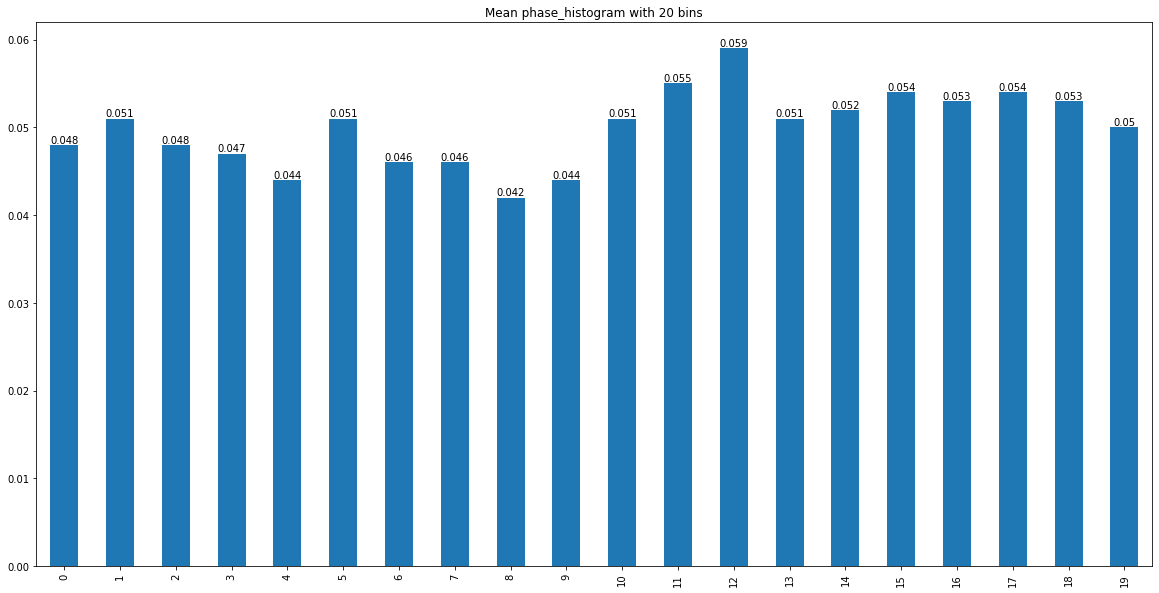

In [109]:
fig , ax = plt.subplots(figsize = (20,10))
df_20_raw.mean().round(3).plot.bar(ax=ax)
ax.bar_label(ax.containers[0])
ax.set_title('Mean phase_histogram with 20 bins')
# plt.savefig('../presentation_2/mean_20_bins')

In [110]:
angle, length = get_complex_vector(phase=np.arange(20) / 20 * 2 * np.pi, amplitude=df_20_raw.mean().values)

/tmp/ipykernel_26503/3326889762.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  angle, length = get_complex_vector(phase=np.arange(20) / 20 * 2 * np.pi, amplitude=df_20_raw.mean().values)


In [111]:
length

0.0021149954

In [62]:
concat = []
for patient in patients:
    concat.append(pd.read_excel(f'../df_analyse/resp_features_{patient}.xlsx', index_col = 0))
df_all_rsp_features = pd.concat(concat)

In [64]:
df_20

,patient,stage,norm,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,P1,N2,no,116.000000,98.000000,121.000000,95.000000,98.000000,106.000000,101.000000,...,110.000000,114.000000,117.000000,108.000000,114.000000,116.000000,153.000000,125.000000,112.000000,102.000000
0,P1,N2,yes,0.052751,0.044566,0.055025,0.043201,0.044566,0.048204,0.045930,...,0.050023,0.051842,0.053206,0.049113,0.051842,0.052751,0.069577,0.056844,0.050932,0.046385
0,P2,N2,no,116.000000,103.000000,104.000000,120.000000,119.000000,126.000000,116.000000,...,182.000000,181.000000,146.000000,153.000000,151.000000,144.000000,137.000000,139.000000,146.000000,117.000000
0,P2,N2,yes,0.044006,0.039074,0.039454,0.045524,0.045144,0.047800,0.044006,...,0.069044,0.068665,0.055387,0.058042,0.057284,0.054628,0.051973,0.052731,0.055387,0.044385
0,P3,N2,no,162.000000,145.000000,104.000000,112.000000,140.000000,130.000000,129.000000,...,158.000000,175.000000,207.000000,205.000000,209.000000,195.000000,159.000000,185.000000,204.000000,158.000000
0,P3,N2,yes,0.049375,0.044194,0.031698,0.034136,0.042670,0.039622,0.039317,...,0.048156,0.053337,0.063091,0.062481,0.063700,0.059433,0.048461,0.056385,0.062176,0.048156
0,P4,N2,no,118.000000,112.000000,130.000000,116.000000,128.000000,134.000000,105.000000,...,114.000000,139.000000,148.000000,132.000000,152.000000,120.000000,131.000000,116.000000,107.000000,119.000000
0,P4,N2,yes,0.047851,0.045418,0.052717,0.047040,0.051906,0.054339,0.042579,...,0.046229,0.056367,0.060016,0.053528,0.061638,0.048662,0.053122,0.047040,0.043390,0.048256
0,P5,N2,no,78.000000,121.000000,117.000000,111.000000,103.000000,113.000000,101.000000,...,111.000000,115.000000,144.000000,125.000000,137.000000,130.000000,155.000000,146.000000,112.000000,116.000000
0,P5,N2,yes,0.033065,0.051293,0.049597,0.047054,0.043663,0.047902,0.042815,...,0.047054,0.048749,0.061043,0.052989,0.058075,0.055108,0.065706,0.061891,0.047478,0.049173


In [65]:
df_to_study = df_20.set_index(['patient','stage','norm'])
rows = []
for patient in patients:
    for norm in ['no','yes']:
        angle, length = get_complex_vector(phase=phases_in_radian(), amplitude=df_to_study.loc[(patient, 'N2', norm) , :])
        row = [patient , norm , angle, length]
        rows.append(row)
df_mi = pd.DataFrame(rows, columns = ['patient' , 'norm' , 'angle' , 'length'])
    

In [66]:
df_mi

,patient,norm,angle,length
0,P1,no,5.658145,9.797327
1,P1,yes,5.658145,0.004455
2,P2,no,4.758848,10.326506
3,P2,yes,4.758848,0.003917
4,P3,no,4.916801,17.267103
5,P3,yes,4.916801,0.005263
6,P4,no,5.623581,5.692597
7,P4,yes,5.623581,0.002308
8,P5,no,5.365995,10.258523
9,P5,yes,5.365995,0.004349


In [76]:
patients[:len(patients)//2]

['P1', 'P2', 'P3', 'P4', 'P5']

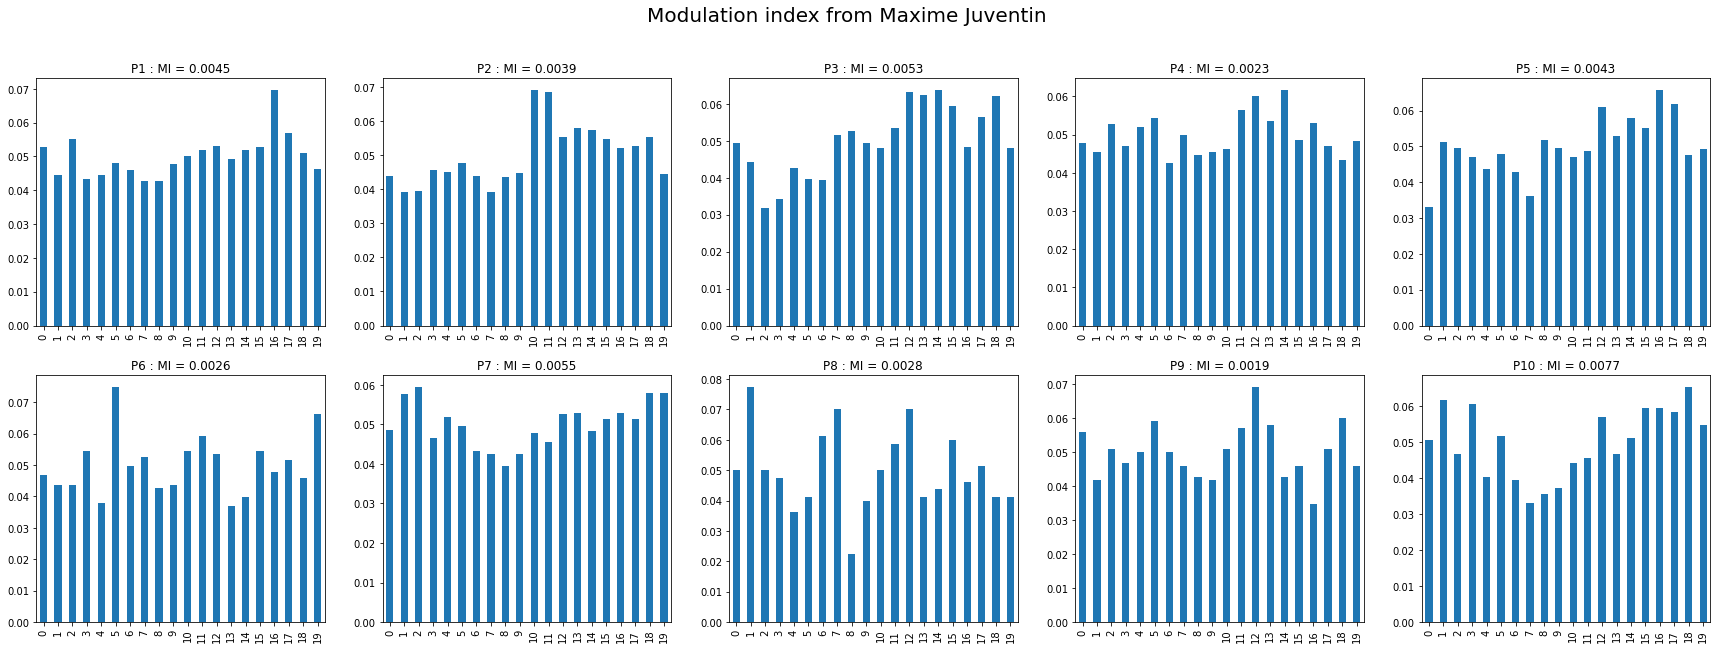

In [94]:
fig ,axs = plt.subplots(nrows = 2, ncols = 5, figsize = (30,10))
fig.suptitle('Modulation index from Maxime Juventin', fontsize = 20)

patient_1 = patients[:len(patients)//2]
patient_2 = patients[len(patients)//2:]
listes = [patient_1,patient_2]
for row, liste in enumerate(listes):
    for col, patient in enumerate(liste):
        ax = axs[row,col]
        df_20[df_20['norm'] == 'yes'].set_index(['patient','stage','norm']).loc[(patient,'N2','yes'), :].plot.bar(ax=ax)
        length = df_mi.set_index(['patient','norm']).loc[(patient,'yes'),'length']
        title = f'{patient} : MI = {round(float(length), 4)}'
        ax.set_title(title)
# plt.savefig('../presentation_2/MI_max_20bins')

In [93]:
df_mi[df_mi['norm'] == 'yes'].mean()

/tmp/ipykernel_26503/2665531414.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_mi[df_mi['norm'] == 'yes'].mean()


angle     5.083594
length    0.004086
dtype: float64